### LICENSE PLACE DETECTION AND RECOGNITION

In [40]:
# !pip install albumentations==0.4.6



In [41]:
import cv2
import ast

import numpy as np 
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

from sklearn import model_selection

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from tqdm.notebook import tqdm

import warnings
import os
import random
warnings.filterwarnings("ignore")
from glob import glob
import xml.etree.ElementTree as xet
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [2]:
def load_images(directory):
    images = []

    for filepath in tqdm(os.listdir(directory)):
        img_path = os.path.join(directory,filepath)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(224,224))
        img = cv2.medianBlur(img,5)
        images.append(img)
    
    images = np.array(images).reshape(len(images),224,224,3)
    return images

In [3]:
path = glob("../input/car-plate-detection/annotations/*.xml")
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])

for filename in path:
    data = xet.parse(filename)
    root = data.getroot()
    obj = root.find('object')
    labels_info = obj.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [4]:
valid_df = pd.DataFrame(labels_dict)
valid_df.to_csv('labels.csv',index=False)
valid_df.head()

,filepath,xmin,xmax,ymin,ymax
0,../input/car-plate-detection/annotations/Cars3...,209,283,135,169
1,../input/car-plate-detection/annotations/Cars1...,191,242,147,169
2,../input/car-plate-detection/annotations/Cars7...,115,277,115,153
3,../input/car-plate-detection/annotations/Cars1...,36,62,175,186
4,../input/car-plate-detection/annotations/Cars2...,71,215,205,246


In [8]:
valid_df['filepath'] = valid_df['filepath'].str.replace('../input/car-plate-detection/annotations/','')
valid_df['filepath'] = valid_df['filepath'].str.replace('.xml','.png')
valid_df['class'] = 'license'
valid_df = valid_df.rename(columns = {'filepath':'img_id'})
valid_df.head()

,img_id,xmin,xmax,ymin,ymax,class
0,Cars339.png,209,283,135,169,license
1,Cars13.png,191,242,147,169,license
2,Cars74.png,115,277,115,153,license
3,Cars16.png,36,62,175,186,license
4,Cars291.png,71,215,205,246,license


In [9]:
df = pd.read_csv('/kaggle/input/license-plates/license_plates_detection_train.csv')
df['class'] = 'license'
df.head()

,img_id,ymin,xmin,ymax,xmax,class
0,1.jpg,276,94,326,169,license
1,10.jpg,311,395,344,444,license
2,100.jpg,406,263,450,434,license
3,101.jpg,283,363,315,494,license
4,102.jpg,139,42,280,222,license


In [10]:
df.shape, valid_df.shape

((900, 6), (433, 6))

In [11]:
classes_la = {"license": 1}

df["class"] = df["class"].apply(lambda x: classes_la[x])
valid_df["class"] = valid_df["class"].apply(lambda x: classes_la[x])

### Plotting the Images

In [16]:
# group by all bounding boxes (bbox)
df_grp = df.groupby(['img_id'])
df_grp

In [19]:
path = '/kaggle/input/license-plates/license_plates/license_plates/license_plates_detection_train/license_plates_detection_train/'
def plot_image(image_name):
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    img = immg.imread(path+name)
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(bbox)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()


   xmin  ymin  xmax  ymax
0    94   276   169   326


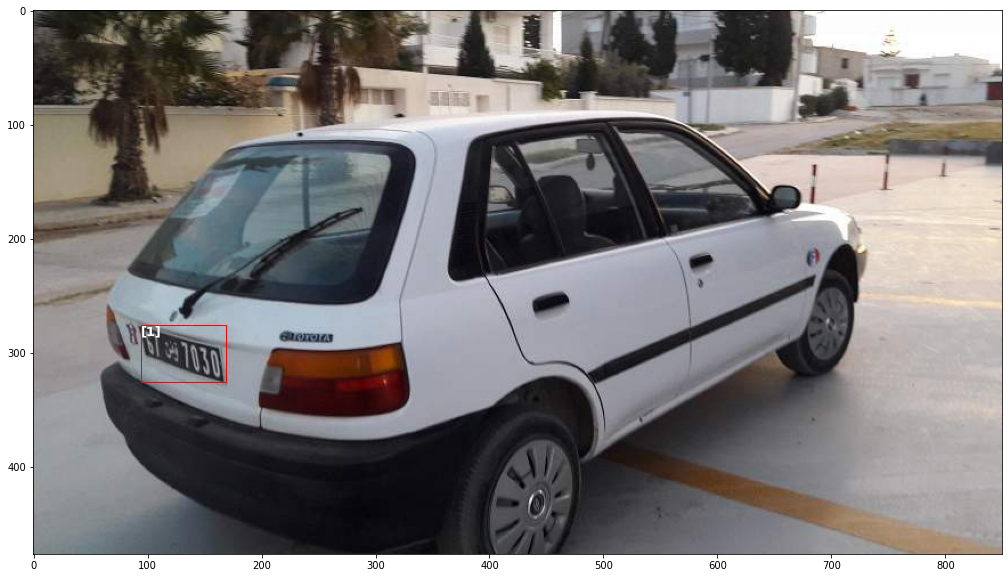

In [20]:
name = df.img_id.unique()[0]
plot_image(name)

     xmin  ymin  xmax  ymax
700   417   173   443   250


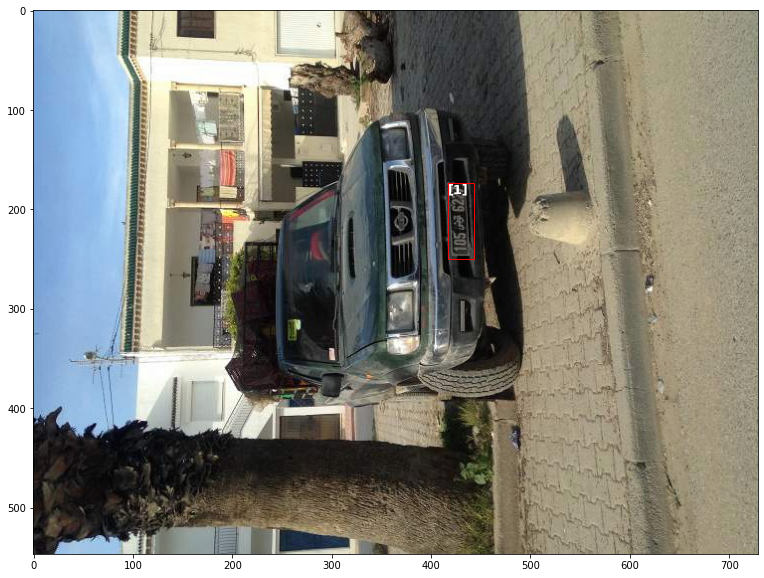

In [21]:
name = df.img_id.unique()[700]
plot_image(name)

    xmin  ymin  xmax  ymax
67   255   314   428   359


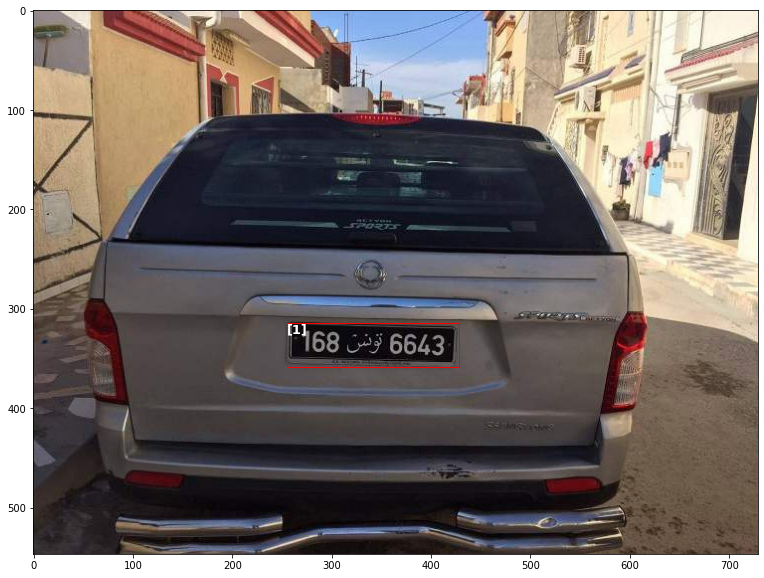

In [22]:
name = df.img_id.unique()[67]
plot_image(name)

### Create a Custom Dataset

In [43]:
class LicensePlate(object):
    def __init__(self, df, IMG_DIR, transforms):
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df.img_id.unique()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_values = self.df[self.df['img_id'] == image_id]
        image = cv2.imread(self.img_dir+image_id,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=255.0
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = image_values["class"].values
        labels = torch.tensor(labels)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)        
        
        if self.transforms:
            sample = {
                'image':image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            
        sample = self.transforms(**sample)
        image = sample['image']
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        
        return torch.tensor(image), target, image_id
        


### AUGMENTATIONS

In [44]:
def get_train_transform():
    return A.Compose([
        A.Resize(512,512),
        A.Transpose(),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.1,0.1), 
            contrast_limit=(-0.1, 0.1), 
            p=0.5
        ),
        A.HueSaturationValue(
            hue_shift_limit=0.2, 
            sat_shift_limit=0.2, 
            val_shift_limit=0.2, 
            p=0.5
            ), 


        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Resize(512, 512), 
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

### LOAD LICENSE PLATE DATASET AND PERFORM THE TRANSFORMATIONS

In [45]:
license_dataset = LicensePlate(df, path, get_train_transform())

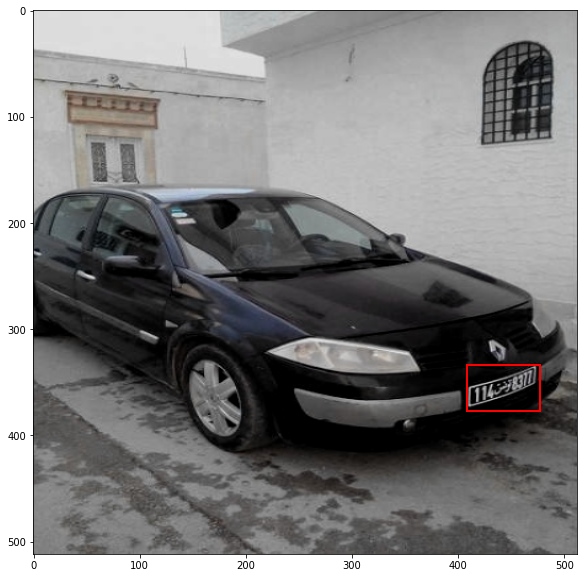

In [51]:
img, tar, _ = license_dataset[random.randint(0,906)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in tar["labels"].tolist():
    classes_la = {1:"license"}
    l = classes_la[l]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
#         ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold') # Useful if you have many classes
        ax.add_patch(rect)
    plt.show()
